In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
import seaborn as sns
import scipy as sp
import dask
from toydown import GeoUnit, ToyDown
import time
import random
from dask.distributed import Client
client = Client()

## Set up Toy Model

In [2]:
def create_tree_from_leaves(leaf_dict):
    """ Given a dictionary, where the keys are the names of leaf nodes (labeled by their path)
        and the corresponding value is the associated attribute counts, this function returns
        the list of GeoUnits that defines the corresponding tree.
    """
    nodes = leaf_dict.copy()
    h = len(list(leaf_dict.keys())[0])
    n = len(list(leaf_dict.values())[0])
    
    for i in range(2, h+1):
        level_names = list(set(list(map(lambda s: s[:-(i-1)], leaf_dict.keys()))))
        level_counts = [np.zeros(n)]*len(level_names)
        for node in level_names:
            nodes[node] = np.array([v for k, v in leaf_dict.items() if k.startswith(node)]).sum(axis=0)
        
    return [GeoUnit(k, k[:-1], v) if k != "1" else GeoUnit(k, None, v) for k, v in nodes.items()]

In [3]:
leaves = {'1133': np.array([152.01127753, 138.84528446,  13.16599307]),
          '1132': np.array([212.33036409, 161.9876171 ,  50.34274699]),
          '1131': np.array([200.25783133, 120.10254376,  80.15528757]),
          '1123': np.array([279.75309343, 116.00477968, 163.74831374]),
          '1122': np.array([294.78230712, 100.31018182, 194.4721253 ]),
          '1121': np.array([290.33488693, 112.70811816, 177.62676877]),
          '1113': np.array([261.15279716, 102.36320046, 158.78959671]),
          '1112': np.array([367.09928003, 101.20197765, 265.89730238]),
          '1111': np.array([345.7709206 ,  60.39187144, 285.37904916]),
          '1233': np.array([152.01127753, 138.84528446,  13.16599307]),
          '1232': np.array([212.33036409, 161.9876171 ,  50.34274699]),
          '1231': np.array([200.25783133, 120.10254376,  80.15528757]),
          '1223': np.array([279.75309343, 116.00477968, 163.74831374]),
          '1222': np.array([294.78230712, 100.31018182, 194.4721253 ]),
          '1221': np.array([290.33488693, 112.70811816, 177.62676877]),
          '1213': np.array([261.15279716, 102.36320046, 158.78959671]),
          '1212': np.array([367.09928003, 101.20197765, 265.89730238]),
          '1211': np.array([345.7709206 ,  60.39187144, 285.37904916])}

#leaf_names = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:3+1], repeat=3-1)]

In [4]:
geounits = create_tree_from_leaves(leaves)
geounits.reverse()
eps = 0.2
eps_split = [1/4, 1/4, 1/4, 1/4]

In [5]:
model = ToyDown(geounits, 4, eps, eps_split, parallel=True)
model.show()

1
├── 11
│   ├── 111
│   │   ├── 1111
│   │   ├── 1112
│   │   └── 1113
│   ├── 112
│   │   ├── 1121
│   │   ├── 1122
│   │   └── 1123
│   └── 113
│       ├── 1131
│       ├── 1132
│       └── 1133
└── 12
    ├── 121
    │   ├── 1211
    │   ├── 1212
    │   └── 1213
    ├── 122
    │   ├── 1221
    │   ├── 1222
    │   └── 1223
    └── 123
        ├── 1231
        ├── 1232
        └── 1233



In [6]:
cons_0_diff = lambda n: [{'type': 'eq', 'fun': lambda x, i=i:  x[i] - np.sum([x[j] for j in range(i+1,i+3)])} 
                         for i in np.arange(n*3, step=3)]

In [7]:
model.noise_and_adjust()

In [9]:
model.get_node("1")

Node(tag=1, identifier=1, data=GeoUnit(name=1, parent=None, attributes=[4806.98551644 2027.83114906 2779.15436738], identifier=1, level=0, noised=[4820.53088612 2029.79639298 2801.25206161], noise=[13.54536968  1.96524392 22.09769423], noise_type=laplacian, adjusted=[4820.53088611 2029.79639297 2801.2520616 ], error=[-13.54536967  -1.96524391 -22.09769422]))

In [248]:
model._ToyDown__noise_tree(model.get_node(model.root))

In [249]:

root = model.get_node(model.root)
objective_fun = lambda n: lambda x: sp.linalg.norm(x-n, ord=1)

In [351]:
from scipy.optimize import minimize

def adjust_children(model, node, adj_par, objective_fun, node_cons, bounds, 
                    parental_equality, maxiter, verbose):
        """ Adjusts the children to add up to the parent.
        """
#         time.sleep(random.random())
        children = model.children(node.identifier)
        num_attributes = node.data.attributes.shape[0]
        num_children = len(children)
        noised_children = np.append([], [child.data.noised for child in children])
        unnoised_children = np.append([], [child.data.attributes for child in children])
        
        bnds = [(0, None)]*(num_children*num_attributes) if bounds == "non-negative" else bounds(num_children)

        if parental_equality:
            cons_children = [{'type': 'eq', 'fun': lambda x: np.dot(adj_par - np.sum(x.reshape(num_children, num_attributes), axis=0),
                                                                    adj_par - np.sum(x.reshape(num_children, num_attributes), axis=0))}]
            if not node_cons:
                cons = cons_children
            else:
                cons = node_cons(num_children) + cons_children
        
        if verbose: print("Adjusting children of {}".format(node.data.name))
        adj = minimize(objective_fun(noised_children), unnoised_children, constraints=cons, 
                       bounds=bnds, options={"maxiter": maxiter, "disp": verbose})
        adjusted_children = adj.x

        return [(children[i].data.name, adjusted_child) 
                for i, adjusted_child in enumerate(np.split(adjusted_children, num_children))]


@dask.delayed
def adjust_tree_async(model, node, node_adj, objective_fun, node_cons, bounds, 
                      parental_equality, maxiter, verbose):
        """ Recursively noises children and then "adjusts" the children to sum
            up to the population of the parent.
        """
        
        if node.is_leaf():
            return {node.data.name: node_adj}

        # adjust children
        adj_children = adjust_children(model, node, node_adj, objective_fun, node_cons, bounds,
                                             parental_equality, maxiter, verbose)

        # recurse
        rs = dask.compute([adjust_tree_async(model, model.get_node(child_id), adj_child, objective_fun, 
                                             node_cons, bounds, parental_equality, maxiter, verbose) 
                           for child_id, adj_child in adj_children])[0]
        
        return {**{k: v for d in rs for k, v in d.items()}, **{node.data.name: node_adj}}
    
def adjusted_root(model, root, objective_fun, node_cons, bounds, 
                      parental_equality, maxiter, verbose):
    # Returns adjusted root
    bnds = [(0, None)]*(root.data.attributes.shape[0]) if bounds == "non-negative" else bounds

    cons = node_cons if not node_cons else node_cons(1)
    if verbose: print("Adjusting root node {}".format(root.data.name))
    adj = minimize(objective_fun(root.data.noised), root.data.attributes, 
                   constraints=cons, bounds=bnds, options={"maxiter": maxiter, "disp": verbose})
    
    return(adj.x)

In [352]:
adj_root = adjusted_root(model, root, objective_fun, cons_0_diff, "non-negative", True, 200, False)

In [353]:
dtree = adjust_tree_async(model, root, adj_root, objective_fun, cons_0_diff, "non-negative", True, 200, False)

In [354]:
r = dtree.compute()

In [355]:
r

{'1121': array([299.66250147, 121.47735908, 178.18514239]),
 '1122': array([288.31485522, 101.18188952, 187.1329657 ]),
 '1123': array([274.29785863, 118.90092159, 155.39693704]),
 '112': array([862.27521912, 341.56017227, 520.71504685]),
 '1131': array([193.11330837, 119.85805068,  73.25525769]),
 '1132': array([221.68021982, 169.99031337,  51.68990645]),
 '1133': array([150.89032962, 139.94486819,  10.94546143]),
 '113': array([565.68342784, 429.79351469, 135.88991315]),
 '1111': array([352.17337207,  64.31632217, 287.85704991]),
 '1112': array([368.96574577, 112.40282459, 256.56292118]),
 '1113': array([253.51861998,  96.54450989, 156.97411008]),
 '111': array([974.65800137, 273.26407023, 701.39393114]),
 '11': array([2402.61616113, 1044.61729057, 1357.99887057]),
 '1211': array([363.33091839,  83.25290944, 280.07800895]),
 '1212': array([364.97741293, 114.2220832 , 250.75532973]),
 '1213': array([262.20291235,  70.02058935, 192.18232301]),
 '121': array([990.51092179, 267.49581484,

In [157]:
adjust_tree_async(model, root,adj_root, objective_fun, cons_0_diff, "non-negative", True, 200, False)

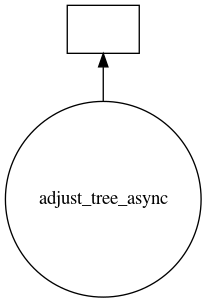

In [140]:
dtree.visualize()

In [ ]:
## Given node

## Dask test

In [25]:

@dask.delayed
def inc(x):
    time.sleep(random.random())
    return x + 1
@dask.delayed
def dec(x):
    time.sleep(random.random())
    return x - 1
@dask.delayed
def add(x, y):
    time.sleep(random.random())
    return x + y

In [ ]:
zs = []

for i in range(16):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

In [26]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new


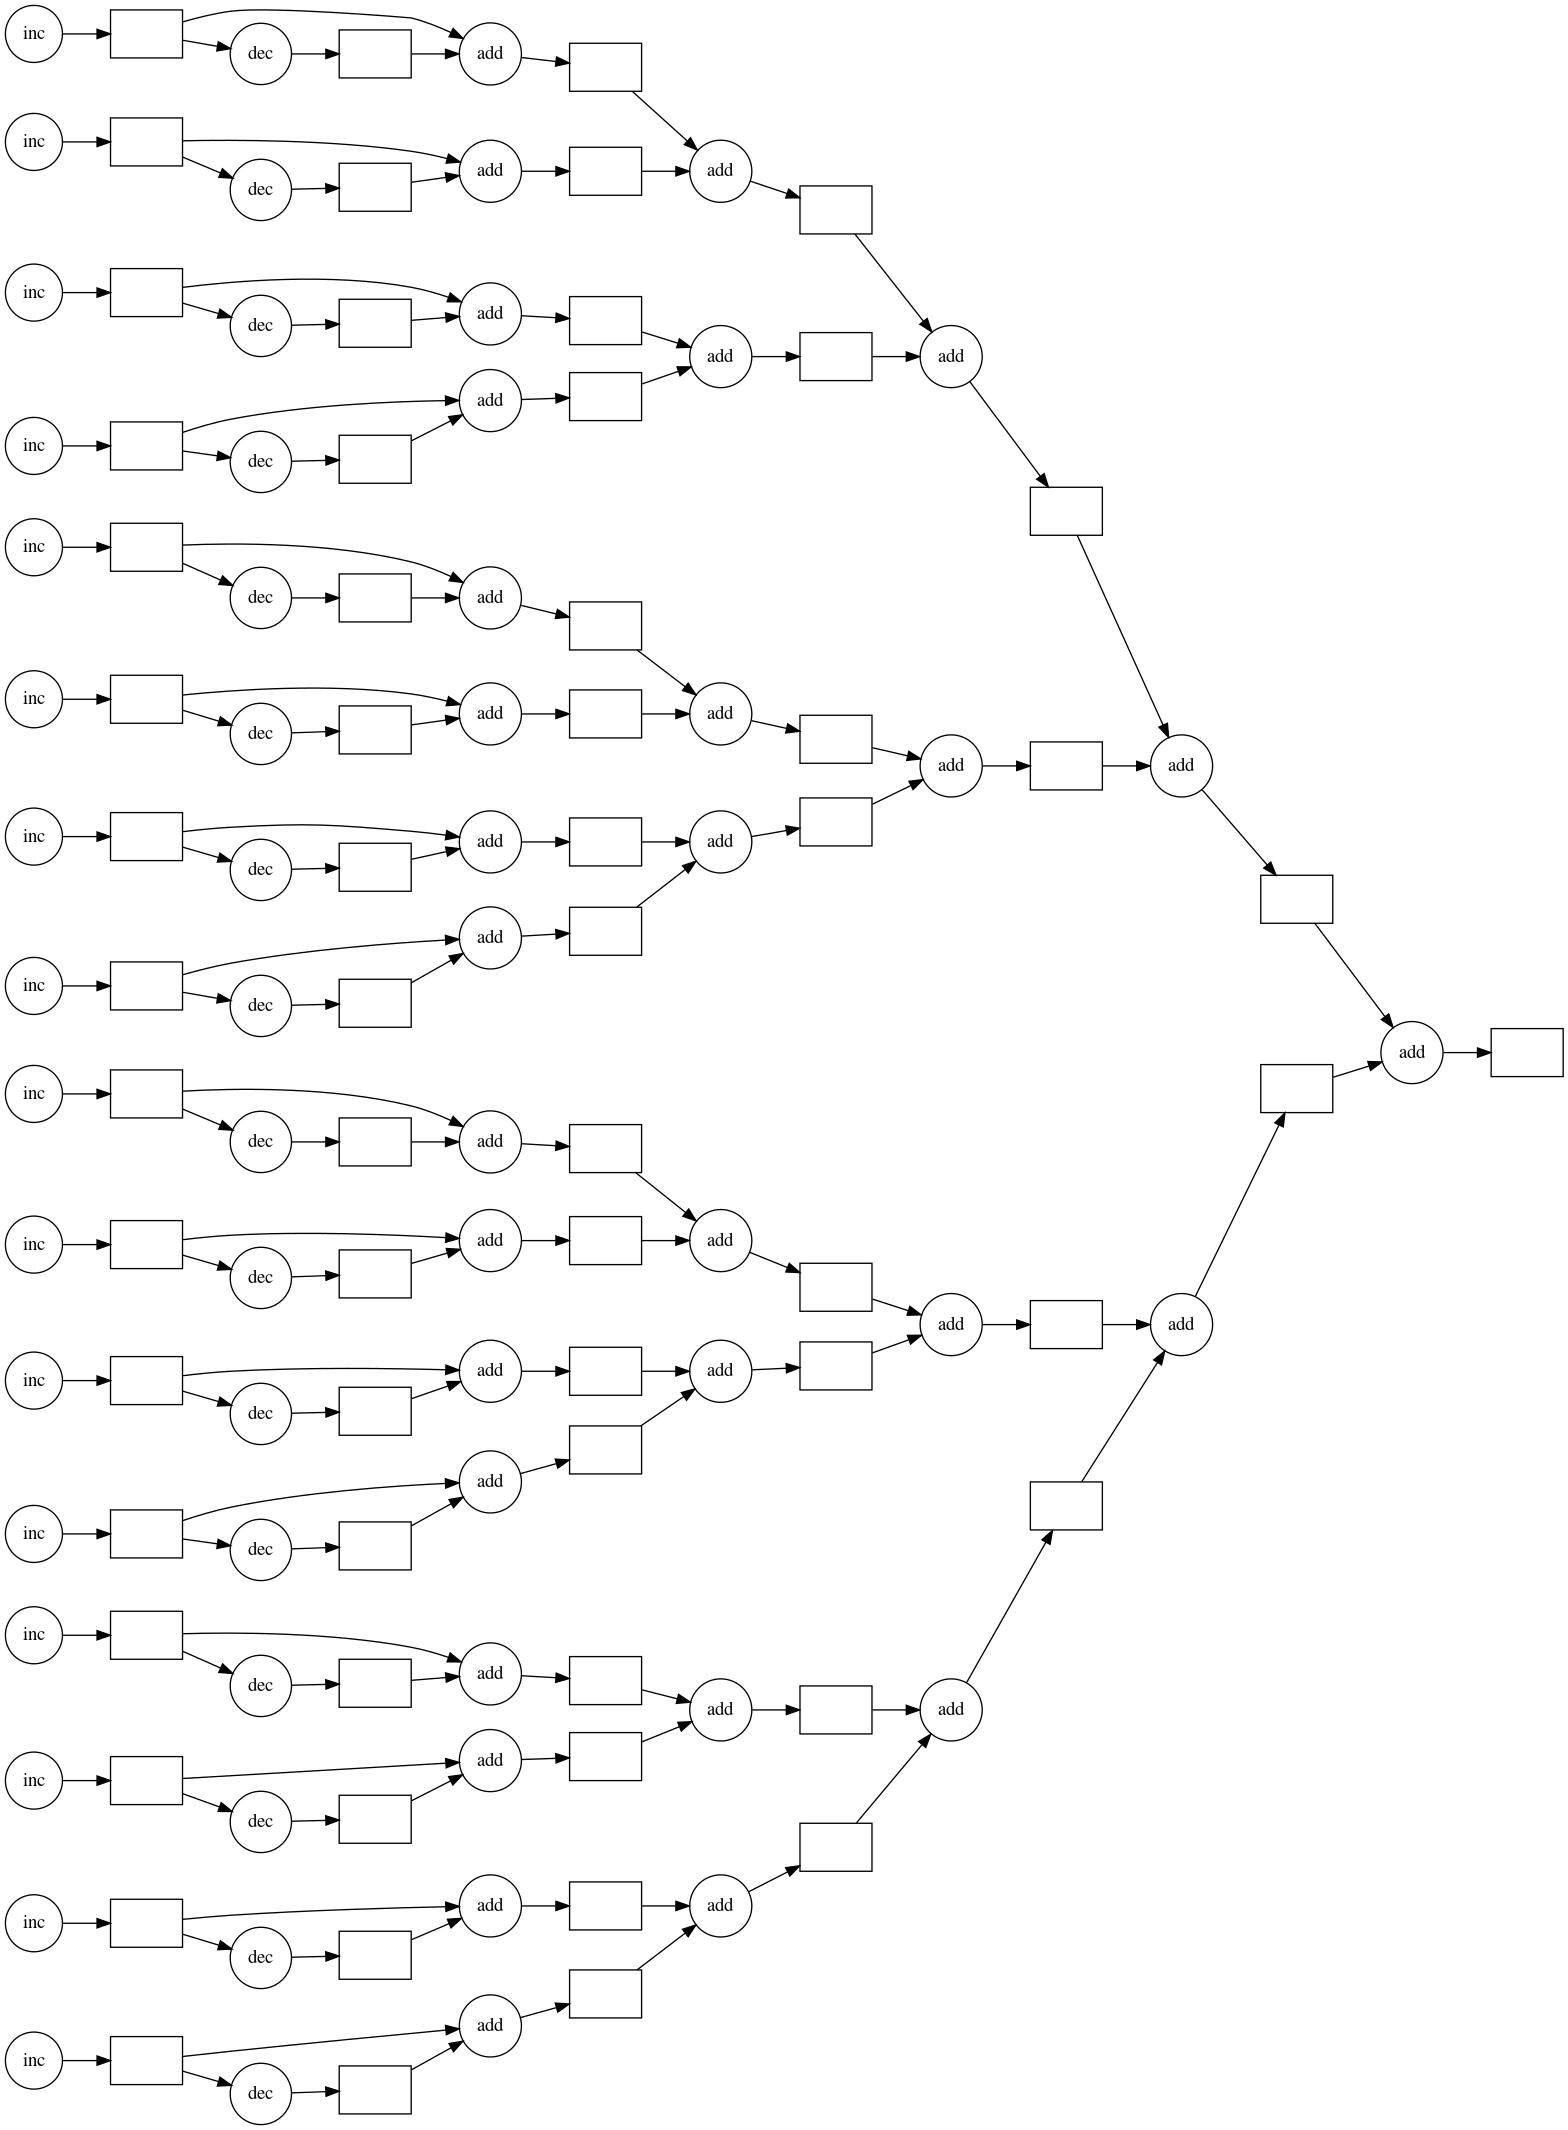

In [27]:
L[0].visualize(rankdir='LR')

In [58]:
dask.compute(L)

([256],)

In [28]:
L[0].compute()

256

In [226]:
@dask.delayed
def fib(n):
    print(n)
    time.sleep(random.random())
    if n < 2:
        return n
    # We can use dask.delayed and dask.compute to launch
    # computation from within tasks
    a = fib(n - 1)  # these calls are delayed
    b = fib(n - 2)
    a, b = dask.compute(a, b)  # execute both in parallel
    return a + b

In [227]:
f = fib(10)

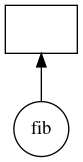

In [228]:
f.visualize()

In [229]:
f

Delayed('fib-8cdbb1d2-8e41-42ab-9b9a-c6214de4f91d')

In [230]:
result = f.compute()

In [7]:
result

55